bayesian CNN: https://medium.com/neuralspace/bayesian-convolutional-neural-networks-with-bayes-by-backprop-c84dcaaf086e

https://arxiv.org/pdf/1703.01961.pdf tests with LeNet

In [1]:
%matplotlib inline
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch.optim as optim
from collections import OrderedDict



import torch.nn as nn
import torch.nn.functional as F


import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from PIL import Image 
import matplotlib.pyplot as plt
from matplotlib import colors


import numpy as np

import time

In [2]:
torch.cuda.empty_cache()

!nvidia-smi

Sun Jun  9 17:46:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.27       Driver Version: 415.27       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P3    19W /  N/A |    852MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# x = np.zeros((3,32,32))
# x = np.rollaxis(x,0,3)
# np.shape(x)

In [4]:
# def test_accuracy(net, dataloader):
#   ########TESTING PHASE###########
  
#     #check accuracy on whole test set
#     correct = 0
#     total = 0
#     net.eval() #important for deactivating dropout and correctly use batchnorm accumulated statistics
#     with torch.no_grad():
#         for data in dataloader:
#             images, labels = data
#             images = images.cuda()
#             labels = labels.cuda()
#             outputs = net(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     accuracy = 100 * correct / total
#     print('Accuracy of the network on the test set: %d %%' % (
#     accuracy))
#     return accuracy

def predict(x):
    num_samples = 10

    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    
    _, predicted = torch.max(mean, 1)
    return(predicted)

classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    npimg =  np.rollaxis(npimg,0,3)
    ax.imshow(npimg,  interpolation='nearest')
    plt.show()
    
def test_batch(images, labels, plot=True):
    
    
#     images = images.cuda()
#     labels = labels.cuda()
    y = give_uncertainities(images)

#     print(y)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("actual class: ",classes[labels[i].item()])
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False

    
        for j, _class  in enumerate(classes):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        if predicted_for_images!=0:
            print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(10)] # numsamples
#     yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    yhats = [F.log_softmax(model(x.cuda()).data, 1).detach().cpu().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [5]:
n_classes = 10


transform_train = transforms.Compose(
    [
#              transforms.Grayscale(1),

     transforms.Resize((40,40)), #not a problem as CIFAR is 32x32 anyway.
     transforms.RandomResizedCrop(32,scale=(32/40,32/40)),   
             transforms.RandomHorizontalFlip(p=0.5),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#      transforms.Normalize((0.5,), (0.5,)),
     ])

transform_test = transforms.Compose(
    [
#              transforms.Grayscale(1),

     transforms.Resize((40,40)),
     transforms.RandomResizedCrop(32,scale=(32/40,32/40)),   
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
#      transforms.Normalize((0.5,), (0.5,)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)



testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4,drop_last=True)



Files already downloaded and verified
Files already downloaded and verified


In [12]:
!nvidia-smi

Sun Jun  9 17:49:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.27       Driver Version: 415.27       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P2    27W /  N/A |   1377MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
# function to define an old style fully connected network (multilayer perceptrons)
class old_nn(nn.Module):
    def __init__(self):
        super(old_nn, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x): #activation functions?
        x = x.view(x.shape[0], -1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(64 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x

    #function to define the convolutional network
class CNN_v2(nn.Module):
    def __init__(self):
        super(CNN_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x

#function to define the convolutional network
class CNN_v3(nn.Module):
    def __init__(self):
        super(CNN_v3, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(512 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x

#function to define the convolutional network
class CNN_v4(nn.Module):
    def __init__(self):
        super(CNN_v4, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, 512, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(1024 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x
    
#function to define the convolutional network
class CNN_v5(nn.Module):
    def __init__(self, question = "c"):
        super(CNN_v5, self).__init__()
        self.question=question
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
        self.conv1_bn = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        if question!="b":
            self.fc1 = nn.Linear(256 * 4 * 4, 4096)
            self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 
        else:
            self.fc1 = nn.Linear(256 * 4 * 4, 8192)
            self.fc2 = nn.Linear(8192, n_classes) #last FC for classification 
        self.dropout_layer=nn.Dropout(0.5)

            
    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        if self.question=="c":
           # x = F.dropout(x,p=0.5)  # checked: this dropout is kept on prediction on test set! got to use nn.dropout instead.
            x=self.dropout_layer(x)
        x = self.fc2(x)
        return x



In [20]:
def Prediction_when_network_can_refuse(testloader):
    correct = 0
    total = 0
    total_predicted_for = 0
    for j, data in enumerate(testloader):
        images, labels = data

        total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
        total += total_minibatch
        correct += correct_minibatch
        total_predicted_for += predictions_minibatch

    print("Prediction when network can refuse:  Total images: ", total, " Skipped: ", total-total_predicted_for)
#     print("Skipped: ", total-total_predicted_for)
    if total_predicted_for !=0:
        print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))
    else: 
        print("Accuracy when made predictions: %d %%" % 0.0)

def Prediction_when_network_is_forced_to_predict(testloader):
    print('Prediction when network is forced to predict')
    correct = 0
    total = 0
    for j, data in enumerate(testloader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        predicted = predict(images)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print("accuracy: %d %%" % (100 * correct / total))



In [18]:

# net = old_nn()
# net.cuda()
# net = CNN()

# net = CNN_v2()
# net = CNN_v3()

net = CNN_v5()

# # net.fc = nn.Linear(512, n_classes)
net= net.cuda() 


layer_names = list( [x for x in net.state_dict().keys() if "weight" in x or "bias" in x])
layers = list([net.state_dict()[key] for key in layer_names]) 
# layer_names = list(net.state_dict().keys())
# layers = list(net.state_dict().values())

def model(x_data, y_data):
    global layers
    global layer_names
    priors = {}
    for index, name in enumerate(layer_names):
        layer = layers[index]
        priors[name] = Normal(loc=torch.zeros_like(layer), scale=torch.ones_like(layer))

    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)
    
softplus = torch.nn.Softplus()

def normal_distribution_layer(layer, name):
       # First layer weight distribution priors
    mu = torch.randn_like(layer)
    sigma = torch.randn_like(layer)
    mu_param = pyro.param(name+"_mu", mu)
    sigma_param = softplus(pyro.param(name+"_sigma", sigma))
    prior = Normal(loc=mu_param, scale=sigma_param)
    return prior

log_softmax = nn.LogSoftmax(dim=1)


def guide(x_data, y_data):
    priors = {}
    global layers
    global layer_names
    for index, name in enumerate(layer_names):
        layer = layers[index]

        priors[name] = normal_distribution_layer(layer, name)

        lifted_module = pyro.random_module("module", net, priors)

    
    return lifted_module().cuda()

optim = Adam({"lr": 0.0001})

svi = SVI(model, guide, optim, loss=Trace_ELBO())
# svi.optim = optim

In [23]:
num_iterations = 50
loss = 0

for j in range(num_iterations):
    t0 = time.time()
    loss = 0
    for batch_id, data in enumerate(trainloader):
        
        x = data[0]

        x = x.cuda()

        y = data[1].cuda()
        
#         print(type(x.cuda()))
        # calculate the loss and take a gradient step
#         loss += svi.step(data[0].view(-1,32*32*256*3), data[1])
        loss += svi.step(x, y)
    normalizer_train = len(trainloader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train, "done in ", time.time()-t0)
#     Prediction_when_network_can_refuse(testloader)
#     Prediction_when_network_is_forced_to_predict(testloader)
    

Epoch  0  Loss  99245.6690665747 done in  26.946764707565308
Epoch  1  Loss  94533.27341895946 done in  27.756917715072632
Epoch  2  Loss  93003.15031552952 done in  27.22239661216736
Epoch  3  Loss  90728.31691194816 done in  26.908854246139526
Epoch  4  Loss  87790.1145728349 done in  26.4778413772583
Epoch  5  Loss  87277.3080481191 done in  28.671170711517334
Epoch  6  Loss  86957.83877493214 done in  28.200217962265015
Epoch  7  Loss  84136.1121832504 done in  27.740725994110107
Epoch  8  Loss  82365.56301319892 done in  26.568724870681763
Epoch  9  Loss  80390.2373234861 done in  26.344013452529907
Epoch  10  Loss  79574.1242321025 done in  26.947530508041382
Epoch  11  Loss  79167.26706798049 done in  26.46192240715027
Epoch  12  Loss  77317.55355509624 done in  27.03538489341736
Epoch  13  Loss  76077.7127333504 done in  27.33658218383789
Epoch  14  Loss  74529.10075489769 done in  26.487334728240967
Epoch  15  Loss  74028.08268301158 done in  26.141849994659424
Epoch  16  Loss

In [24]:
Prediction_when_network_can_refuse(testloader)
Prediction_when_network_is_forced_to_predict(testloader)


Prediction when network can refuse:  Total images:  9984  Skipped:  9776
Accuracy when made predictions: 7 %
Prediction when network is forced to predict
accuracy: 10 %


actual class:  cat


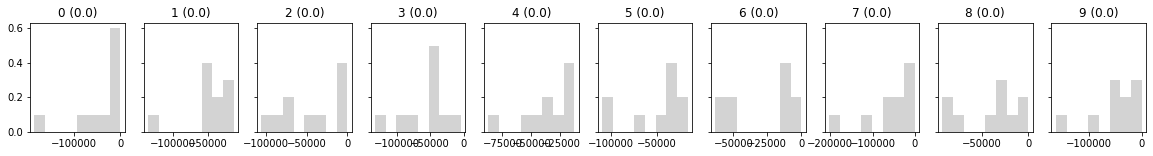

Undecided.


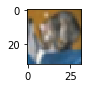

actual class:  ship


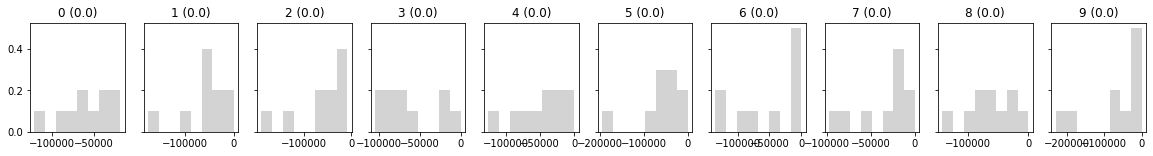

Undecided.


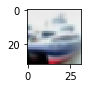

actual class:  ship


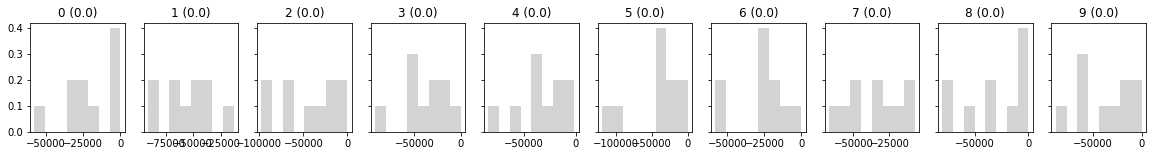

Undecided.


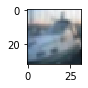

actual class:  airplane


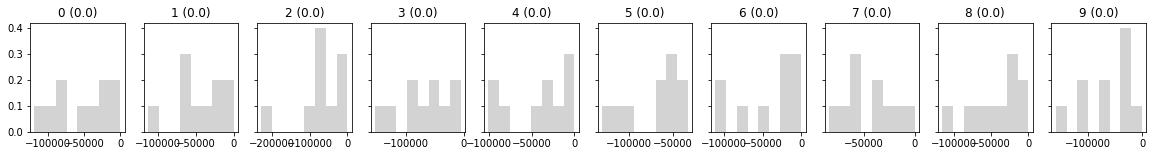

Undecided.


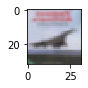

actual class:  frog


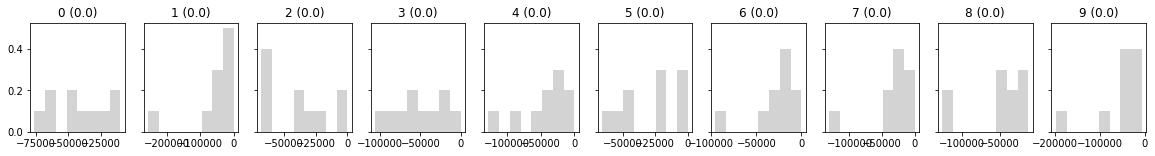

Undecided.


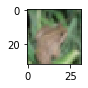

actual class:  frog


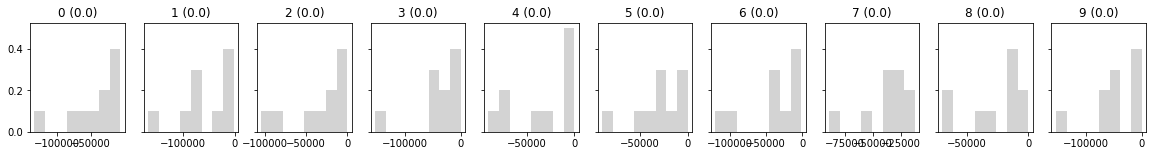

Undecided.


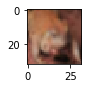

actual class:  automobile


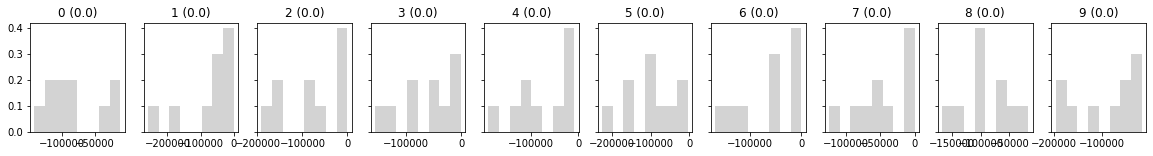

Undecided.


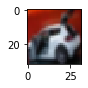

actual class:  frog


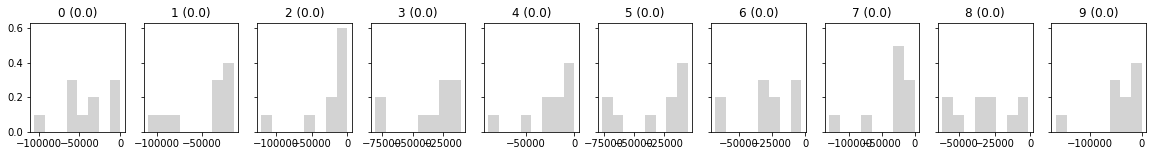

Undecided.


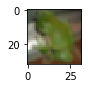

actual class:  cat


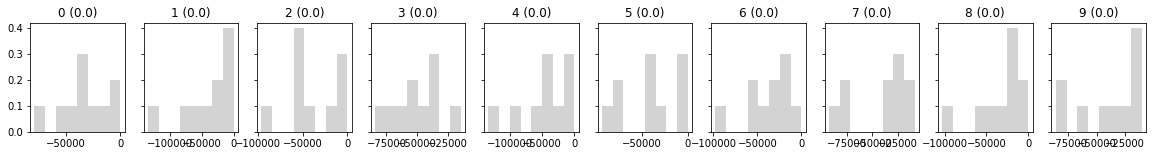

Undecided.


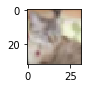

actual class:  automobile


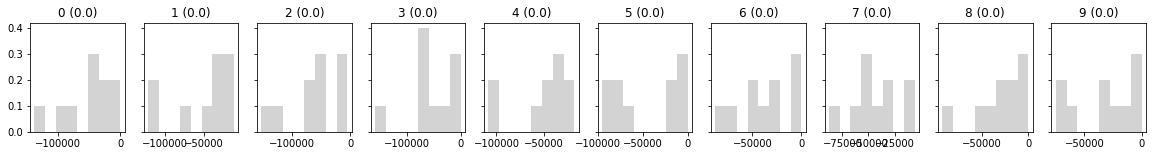

Undecided.


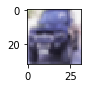

Summary
Total images:  10
Predicted for:  0


(10, 0, 0)

In [22]:
# preparing for evaluation

dataiter = iter(testloader)
images, labels = dataiter.next()

test_batch(images[:10], labels[:10])


# generate random data

# images_random = torch.rand(10,28,28)
# labels_random = torch.randint(0,10, (10,))

# test_batch(images_random, labels_random)